# 합성곱 신경망을 사용한 이미지 분류

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/hg-mldl/blob/master/8-2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

In [1]:
# 경고메세지 안뜨게끔,,
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# 실행마다 동일한 결과를 얻기 위해 케라스에 랜덤 시드를 사용하고 텐서플로 연산을 결정적으로 만듭니다. 
import tensorflow as tf

tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## 패션 MNIST 데이터 불러오기

In [3]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
    keras.datasets.fashion_mnist.load_data()

# (48000, 28, 28) -> (4800, 28, 28, 1)로
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0  

train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state=42)

## 합성곱 신경망 만들기

In [4]:
model = keras.Sequential()

In [5]:
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu',   # 입력 (28,28,1) 필터 32개로 커널 크기(3,3) 세임패딩
                              padding='same', input_shape=(28,28,1)))

In [6]:
model.add(keras.layers.MaxPooling2D(2))  # (2,2)

In [7]:
# 필터 개수만 늘려서 합성곱-풀링 층 추가하기

model.add(keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu', 
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

In [8]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))  # 40퍼 드롭
model.add(keras.layers.Dense(10, activation='softmax'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

#### 층의 구성을 그림으로 표현하는 plot_model() 함수

In [12]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


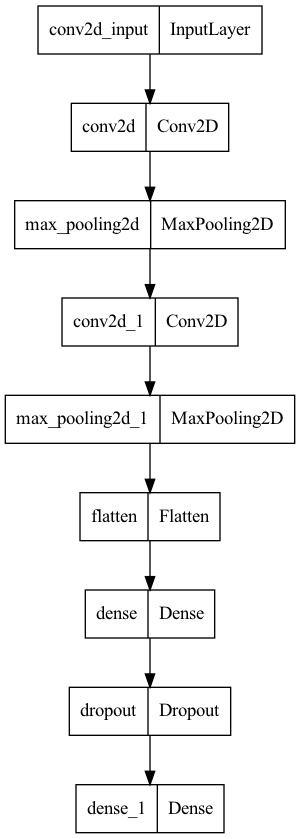

In [10]:
keras.utils.plot_model(model)

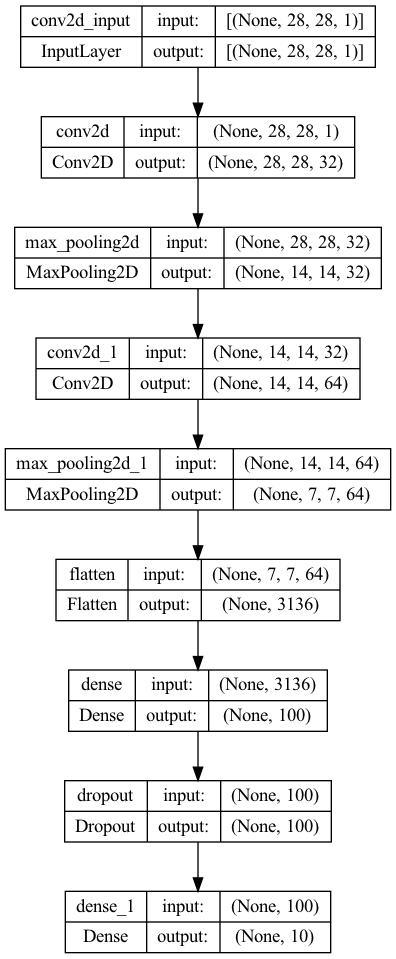

In [11]:
keras.utils.plot_model(model, show_shapes=True)

## 모델 컴파일과 훈련

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
              metrics='accuracy')

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5', 
                                                save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20,
                    validation_data=(val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 [==============================] - 12s 8ms/step - loss: 0.5077 - accuracy: 0.8183 - val_loss: 0.3195 - val_accuracy: 0.8827
Epoch 2/20
1500/1500 [==============================] - 11s 8ms/step - loss: 0.3359 - accuracy: 0.8794 - val_loss: 0.2800 - val_accuracy: 0.8947
Epoch 3/20
1500/1500 [==============================] - 11s 8ms/step - loss: 0.2909 - accuracy: 0.8960 - val_loss: 0.2479 - val_accuracy: 0.9064
Epoch 4/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2577 - accuracy: 0.9063 - val_loss: 0.2405 - val_accuracy: 0.9090
Epoch 5/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2350 - accuracy: 0.9134 - val_loss: 0.2258 - val_accuracy: 0.9164
Epoch 6/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.2166 - accuracy: 0.9210 - val_loss: 0.2163 - val_accuracy: 0.9218
Epoch 7/20
1500/1500 [==============================] - 11s 7ms/step - loss: 0.1977 - accuracy: 0.9260 - val_loss: 0.2160 - val_ac

In [13]:
import matplotlib.pyplot as plt

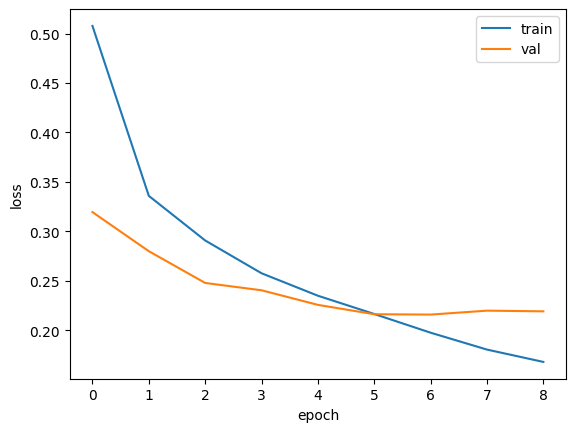

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [15]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 3ms/step - loss: 0.2160 - accuracy: 0.9206


[0.21598438918590546, 0.9205833077430725]

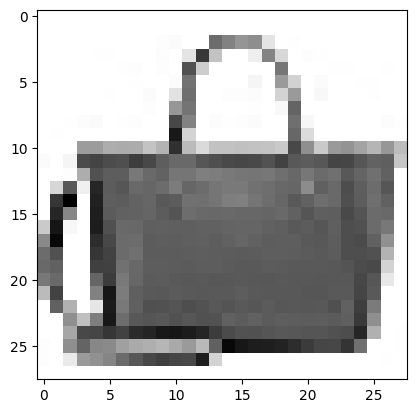

In [16]:
plt.imshow(val_scaled[0].reshape(28, 28), cmap='gray_r')  # 흑백이니까 다시 2차원으로 (28,28,1) -> (28,28)
plt.show()

In [17]:
preds = model.predict(val_scaled[0:1])  # 10개의 클래스에 대한 예측 확률
print(preds)

1/1 [==============================] - 0s 65ms/step
[[1.5703540e-16 2.6147925e-24 6.3015453e-20 1.1584846e-17 6.5234714e-18
  2.7696400e-14 2.5981399e-15 1.3047030e-16 1.0000000e+00 4.0012665e-17]]


유일하게 1인 아홉번째 클래스로 예측중

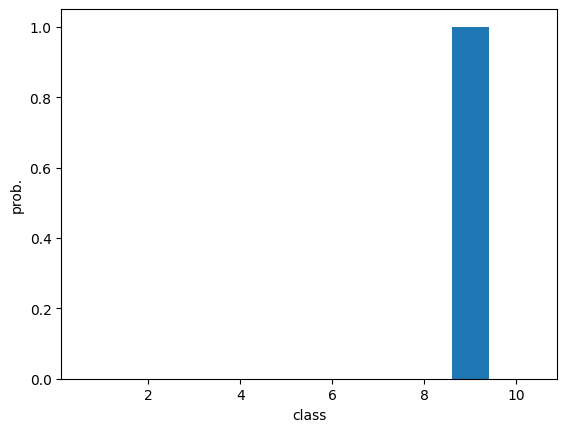

In [18]:
plt.bar(range(1, 11), preds[0])
plt.xlabel('class')
plt.ylabel('prob.')
plt.show()

In [19]:
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트',
           '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']

In [20]:
import numpy as np
print(classes[np.argmax(preds)])  # 배열의 최대값의 인덱스 반환

가방


#### 테스트 세트로 합성곱 신경망의 일반화 (실전 투입) 성능 확인하기

In [21]:
test_scaled = test_input.reshape(-1, 28, 28, 1) / 255.0

In [22]:
model.evaluate(test_scaled, test_target)

313/313 [==============================] - 1s 3ms/step - loss: 0.2395 - accuracy: 0.9137


[0.23952168226242065, 0.9136999845504761]

검증 세트 점수보다 조금 낮다